In [1]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [42]:
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sbn
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,Rescaling,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import pathlib 

data_dir =  pathlib.Path('dataset')

image_count = len(list(data_dir.glob('*/*.jpg')))

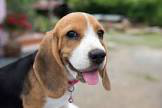

In [4]:
beagle = list(data_dir.glob('Beagle/*'))

beagle_count = len(beagle)

Image.open(str(beagle[2]))

In [5]:
# training ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=40,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest',      # Fill missing pixels
    validation_split=0.2      # Set aside 20% of data for validation
)

In [6]:
# validation ImageDataGenerator
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [7]:
batch_size =32
img_height = 180
img_width = 180

In [8]:
# creating a dataset 

# generates a dataset from image files in a directory
train_ds = train_datagen.flow_from_directory(data_dir,
                                        subset="training",
                                        seed=123,
                                        class_mode='categorical',
                                        target_size=(img_height,img_width),
                                        batch_size=batch_size,
                                        shuffle=True                              
)

# creating validation dataset
val_ds = validation_datagen.flow_from_directory(data_dir,
                                        subset="validation",
                                        class_mode='categorical',
                                        seed=123,
                                        target_size=(img_height,img_width),
                                        batch_size=batch_size,
                                        shuffle=False
)

Found 775 images belonging to 10 classes.
Found 192 images belonging to 10 classes.


In [9]:
class_names = list(train_ds.class_indices.keys())
class_names

['Beagle',
 'Boxer',
 'Bulldog',
 'Dachshund',
 'German_Shepherd',
 'Golden_Retriever',
 'Labrador_Retriever',
 'Poodle',
 'Rottweiler',
 'Yorkshire_Terrier']

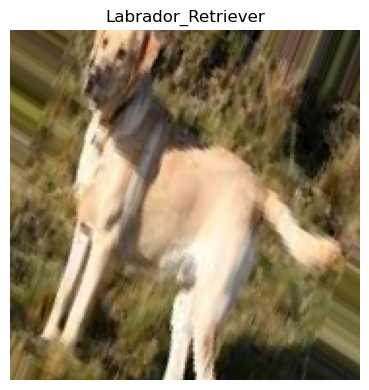

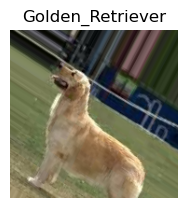

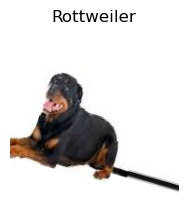

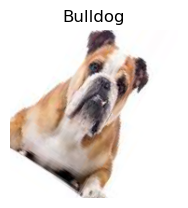

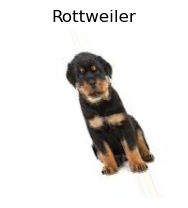

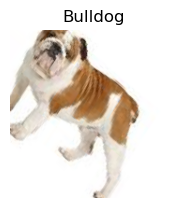

In [10]:
plt.figure(figsize=(10,10))

for i,(images,labels) in enumerate(train_ds):
    for j in range(3):
        label_index = np.argmax(labels[j])
        ax =plt.subplot(2,2,j+1)
        plt.title(class_names[label_index])
        plt.imshow(images[j])
        plt.axis("off")
        plt.show()

    if i ==1:
      break;

In [11]:
num_classes =10

model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D())
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))



In [12]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
model1=model.fit(train_ds,epochs=30,steps_per_epoch=len(train_ds),batch_size=32,validation_data=val_ds,validation_steps=len(val_ds))

Epoch 1/30
25/25 [==============================] - 18s 676ms/step - loss: 2.3260 - accuracy: 0.0916 - val_loss: 2.2863 - val_accuracy: 0.1250
Epoch 2/30
25/25 [==============================] - 17s 661ms/step - loss: 2.2491 - accuracy: 0.1665 - val_loss: 2.2029 - val_accuracy: 0.1979
Epoch 3/30
25/25 [==============================] - 17s 662ms/step - loss: 2.1831 - accuracy: 0.2206 - val_loss: 2.1187 - val_accuracy: 0.2865
Epoch 4/30
25/25 [==============================] - 17s 664ms/step - loss: 2.1315 - accuracy: 0.2155 - val_loss: 1.9853 - val_accuracy: 0.3125
Epoch 5/30
25/25 [==============================] - 17s 658ms/step - loss: 2.0383 - accuracy: 0.2723 - val_loss: 1.8311 - val_accuracy: 0.3854
Epoch 6/30
25/25 [==============================] - 17s 658ms/step - loss: 1.9368 - accuracy: 0.3045 - val_loss: 1.8201 - val_accuracy: 0.3698
Epoch 7/30
25/25 [==============================] - 17s 657ms/step - loss: 1.8992 - accuracy: 0.3329 - val_loss: 1.5721 - val_accuracy: 0.4375

In [14]:
# creating x_test and y_test
num_samples = val_ds.samples

x_test = np.empty((num_samples,img_height,img_width,3))
y_test = np.empty((num_samples,len(class_names)))

for i in range(num_samples // val_ds.batch_size):
    val_images, val_labels = val_ds.next()  # Get the next batch of images and labels
    start_index = i * val_ds.batch_size
    end_index = start_index + val_images.shape[0]  # Get the actual number of images in the batch
    x_test[start_index:end_index] = val_images  # Store images
    y_test[start_index:end_index] = val_labels 


In [15]:
y_pred=model.predict(x_test)

6/6 [==============================] - 1s 61ms/step


In [16]:
model.evaluate(x_test,y_test)

6/6 [==============================] - 0s 61ms/step - loss: 0.2730 - accuracy: 0.9688


[0.27298644185066223, 0.96875]

In [17]:
def predict_breed(index):
    plt.imshow(x_test[index])
    plt.title(class_names[np.argmax(y_pred[index])])
    plt.show()
 

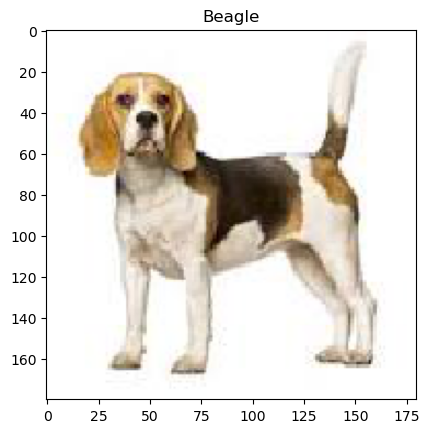

In [21]:
predict_breed(1)

<Figure size 2000x2000 with 0 Axes>

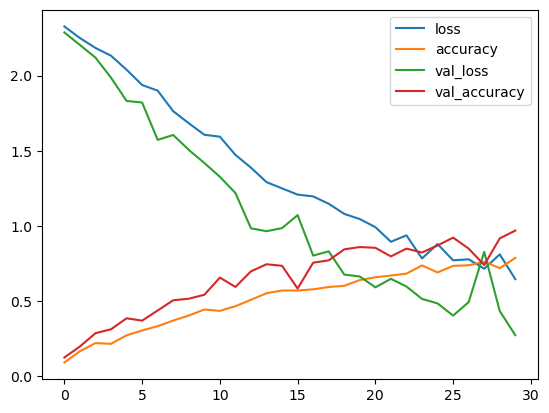

In [22]:
plt.figure(figsize=(20,20))
pd.DataFrame(model1.history).plot()
plt.show()

In [41]:
predicted_classes =np.argmax(y_pred,axis=1)
true_classes = np.argmax(y_test, axis=1) 

cm = classification_report(true_classes,predicted_classes,target_names=class_names)

print(cm)

                    precision    recall  f1-score   support

            Beagle       0.95      0.95      0.95        20
             Boxer       0.95      1.00      0.98        20
           Bulldog       1.00      0.90      0.95        20
         Dachshund       1.00      1.00      1.00        19
   German_Shepherd       0.95      1.00      0.97        19
  Golden_Retriever       0.95      1.00      0.97        18
Labrador_Retriever       0.95      1.00      0.97        19
            Poodle       0.94      0.85      0.89        20
        Rottweiler       1.00      1.00      1.00        17
 Yorkshire_Terrier       1.00      1.00      1.00        20

          accuracy                           0.97       192
         macro avg       0.97      0.97      0.97       192
      weighted avg       0.97      0.97      0.97       192



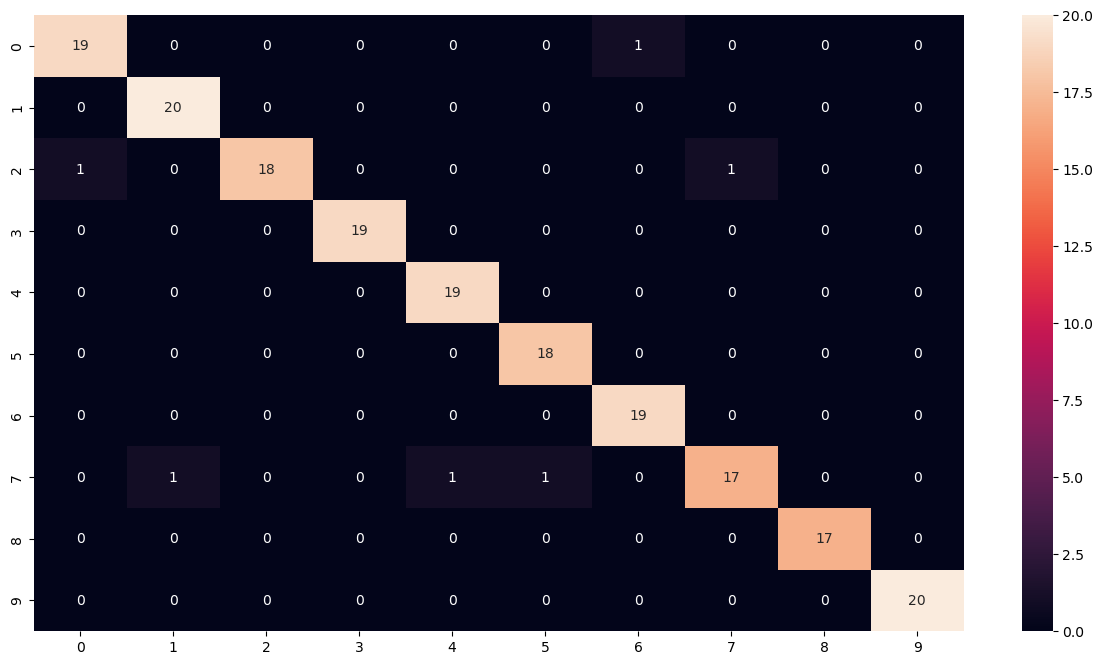

In [49]:
matrix = confusion_matrix(true_classes,predicted_classes)

plt.figure(figsize=(15,8))
sbn.heatmap(data=matrix,annot=True,fmt='d')
plt.show()